
# Fleet Sustainment HVAC Project - Exploratory Data Analysis
## By: bengb
### Date: July 11, 2025

This notebook contains exploratory data analysis of the HVAC maintenance jobs and supply data for the Fleet Sustainment project. This analysis builds upon the initial work done by Jeff and extends it with my own insights and analysis.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

jobs = pd.read_pickle(r'Notebooks/jeff-jobs-cleaned-2025.pkl')
supply = pd.read_pickle(r'Notebooks/jeff-supply-cleaned-2025.pkl')

In [4]:
jobs.head()

,uic,job_seq,action_taken_code,apl,cause_code,cdm_rin,csmp_narrative_summary,date_closing,date_maintenance_action,deferral_reason_code,...,hours_worked_flag,replacement_cost_outlier,total_hours_worked,days_elapsed,level,frame_number,compartment_distance_from_center,location_purpose,days_elapsed_outlier,supplies_ordered
0,R03369,36493414,1,43A030026,7,86KYW,PARTS MISSING,2018-05-08,2018-07-16,2.0,...,True,True,24.0,-69.0,2,200,01,Q,False,True
1,R03369,36493441,1,611330020,7,0KYWX,PARTS MISSING,2018-05-10,2018-07-16,2.0,...,True,False,24.0,-67.0,2,180,0,L,False,True
2,R23170,36496418,1,611330020,7,0UXWY,PARTS MISSING,2018-05-29,2018-07-16,2.0,...,True,False,27.0,-48.0,2,84,0,Q,False,True
3,R21853,36305764,1,18550014,7,02THE,PARTS BROKEN,2018-04-12,2018-05-11,2.0,...,True,True,22.0,-29.0,03,148,2,Q,False,True
4,R23170,36962865,1,213450019,7,0QGUV,DAMPER WILL NOT RESET,2018-11-29,2018-12-13,2.0,...,True,True,20.0,-14.0,2,165,0,Q,False,True


| Column                                      | Meaning                                                                  |
| ------------------------------------------- | ------------------------------------------------------------------------ |
| `uic`, `job_seq`                            | Unique job identifier (you’ll use this to join with `supply`)            |
| `action_taken_code`                         | Type of maintenance performed (1 = part drawn from supply, etc.)         |
| `days_elapsed`                              | Duration of job (important for R\&M analysis)                            |
| `total_hours_worked`                        | Actual labor applied                                                     |
| `days_elapsed_outlier`, `hours_worked_flag` | Outlier flags — use these to clean your data                             |
| `supplies_ordered`                          | Flag if a supply record exists for this job                              |
| `location_purpose`, `level`, `frame_number` | Spatial metadata — **interesting for geospatial or deck-level analysis** |


In [5]:
supply.head()

,jcn,uic,work_center,jsn,date_maintenance_action,date_closing,demand_date,issue_date,issue_apl,issue_eic,...,quantity,unit_price,job_seq,issue_before_demand,supply_days_waiting,tot_price,supply_days_waiting_outlier,quantity_outlier,unit_price_outlier,valid_dates
0,21297EE021067,21297,EE02,1067,2019-10-21,2019-10-23,2019-10-21,2019-10-23,986002160X,T200000,...,1,339.24,38199046,False,2.0,339.24,False,False,False,True
1,03369WG412310,3369,WG41,2310,2020-02-16,2021-11-30,2021-06-15,2021-08-27,319990049,T200000,...,1,398.64,38501779,False,73.0,398.64,False,False,False,True
2,03368RM22080T,3368,RM22,080T,2019-10-04,2020-12-03,2019-10-12,2019-11-18,88A050554X,T200000,...,10,83.42,38127171,False,37.0,834.20,False,True,False,True
3,21297SS401418,21297,SS40,1418,2019-10-17,2019-10-17,2019-10-17,2019-10-17,48A030006,T200000,...,62,8.43,38199258,False,0.0,522.66,False,True,False,True
4,22178VV402163,22178,VV40,2163,2019-10-09,2019-10-22,2019-10-09,2019-10-16,48A030011,T200000,...,2,26.31,38040937,False,7.0,52.62,False,False,False,True


| Column                                | Meaning                                                |
| ------------------------------------- | ------------------------------------------------------ |
| `uic`, `job_seq`, `work_center`       | Used to **join to `jobs`**                             |
| `demand_date`, `issue_date`           | When part was requested vs issued                      |
| `supply_days_waiting`                 | Wait time for parts — potential **predictor of delay** |
| `quantity`, `unit_price`, `tot_price` | Cost info                                              |
| `issue_before_demand`, `valid_dates`  | Data quality flags                                     |
| `issue_apl`, `issue_eic`              | System identifiers for what was ordered                |


In [7]:
jobs['supplies_ordered'].value_counts(normalize=True)

supplies_ordered
False    0.69736
True     0.30264
Name: proportion, dtype: float64

# only 30% involve supply part order

In [ ]:
merged = jobs.merge(supply, on=['uic', 'job_seq'], how='left', indicator=True)
merged['_merge'].value_counts()

In [9]:
filtered = jobs[
    (jobs['days_elapsed_outlier'] != True) &
    (jobs['hours_worked_flag'] != True) &
    (jobs['days_elapsed'].notna())
]

filtered[['days_elapsed', 'total_hours_worked']].describe()

,days_elapsed,total_hours_worked
count,23311.000000,23311.000000
mean,123.591438,7.765433
std,136.317187,6.767511
min,-13.000000,1.000000
25%,17.000000,2.000000
50%,70.000000,5.000000
75%,186.000000,11.000000
max,554.000000,35.000000


Text(0, 0.5, 'Frequency')

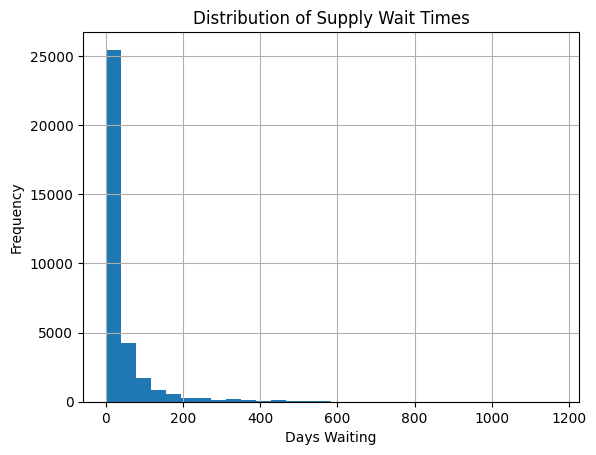

In [8]:
supply['supply_days_waiting'].hist(bins=30)
plt.title("Distribution of Supply Wait Times")
plt.xlabel("Days Waiting")
plt.ylabel("Frequency")

In [ ]:
jobs.groupby('supplies_ordered')[['days_elapsed', 'total_hours_worked']].median()

,days_elapsed,total_hours_worked
supplies_ordered,,
False,123.0,6.0
True,53.0,10.0


In [12]:
supply['issue_apl'].value_counts().head(10)

issue_apl
48A030009    2165
48A030006    1990
48A030005    1702
48A030010     943
48A030012     882
48A030011     866
48A030007     500
750840003     452
610010876     415
32A150008     412
Name: count, dtype: Int64

In [13]:
jobs['equipment_nomenclature'].value_counts().head(10)

equipment_nomenclature
VENT NONMCH PRP     23687
VENTILATION SYST     1406
VENT MACH SPCS F     1078
AIR CONDITIONING      980
NON-MACHINERY SP      749
ANNOUNCING SYSTE      693
SVCE STM POTW HT      639
IC CKT 1MC LOUDS      603
VENTILATION ACCE      388
IC CKT 1MC/3MC A      308
Name: count, dtype: Int64

In [15]:
jobs.groupby("equipment_nomenclature")["days_elapsed"].median().sort_values(ascending=False).head(10)

equipment_nomenclature
TOXIC GAS EXCLUS    835.0
VLVGATE 1.25IPS     733.0
COIL,MAC-3A COOL    711.0
VENT SYS PLT 2      695.0
CHW SYS 9 RTN X-    688.0
AC PLANT NO 6 IN    669.0
REACTOR PLANT 1     654.0
IC CKT 11FD-FLOA    647.0
VENT LOUVERS FR     647.0
IC CKT 11FD-LIQU    647.0
Name: days_elapsed, dtype: float64

In [ ]:
jobs.groupby("equipment_nomenclature")["total_hours_worked"].median().sort_values(ascending=False).head(10)

equipment_nomenclature
MARLO FCU           4746.0
LP AIR SYSTEM       2451.0
LP AIR SYS PIPIN    2451.0
REFR FWD PLANT 1    1626.0
NR 6 AIR CONDITI     742.0
#3 AC COMPRESSOR     726.0
HANGAR BAY 1         601.0
HANGAR BAY 3         601.0
IC CKT 19MC CONN     551.0
VENT NONMCH PR C     520.0
Name: total_hours_worked, dtype: float64

In [19]:
summary = jobs.groupby("equipment_nomenclature").agg({
    "days_elapsed": "median",
    "total_hours_worked": "median",
    "supplies_ordered": "mean"
}).sort_values(by="days_elapsed", ascending=False)
summary.head(25)

,days_elapsed,total_hours_worked,supplies_ordered
equipment_nomenclature,,,
TOXIC GAS EXCLUS,835.0,2.0,0.000000
VLVGATE 1.25IPS,733.0,4.0,0.000000
"COIL,MAC-3A COOL",711.0,2.0,0.000000
VENT SYS PLT 2,695.0,1.0,0.000000
CHW SYS 9 RTN X-,688.0,10.0,0.000000
AC PLANT NO 6 IN,669.0,13.0,0.000000
REACTOR PLANT 1,654.0,151.0,0.000000
IC CKT 11FD-FLOA,647.0,9.0,0.272727
VENT LOUVERS FR,647.0,1.0,0.000000


In [22]:
# Define "stalled but low effort" jobs
backlog_candidates = jobs[
    (jobs['days_elapsed'] > 600) &
    (jobs['total_hours_worked'] <= 5) &
    (jobs['supplies_ordered'] == False)
]


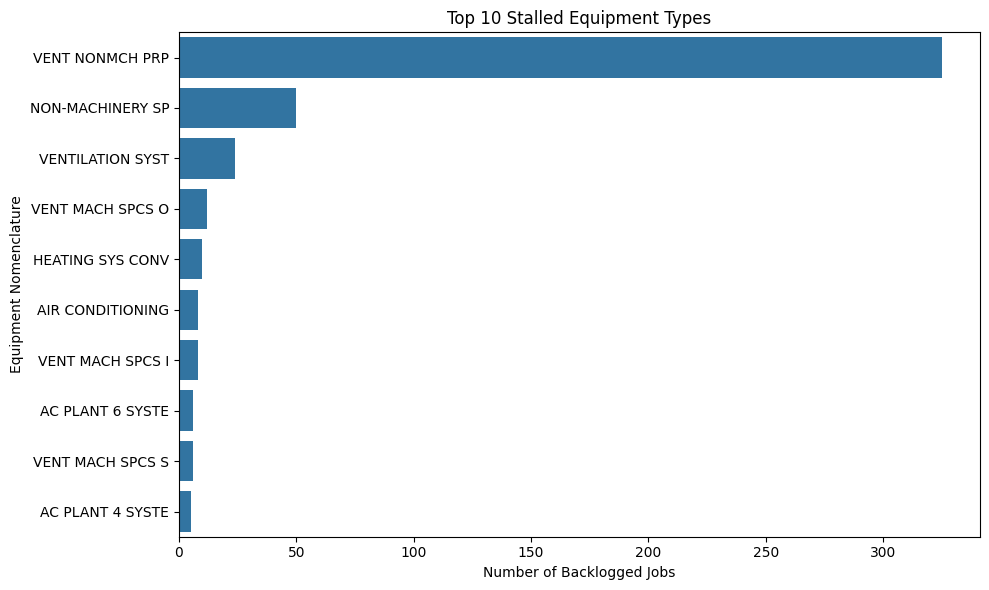

In [23]:
top_equipment = backlog_candidates['equipment_nomenclature'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_equipment.values, y=top_equipment.index)
plt.title("Top 10 Stalled Equipment Types")
plt.xlabel("Number of Backlogged Jobs")
plt.ylabel("Equipment Nomenclature")
plt.tight_layout()
plt.show()


In [27]:
print(f"Backlog candidates: {len(backlog_candidates):,} out of {len(jobs):,} total jobs")


Backlog candidates: 543 out of 47,350 total jobs


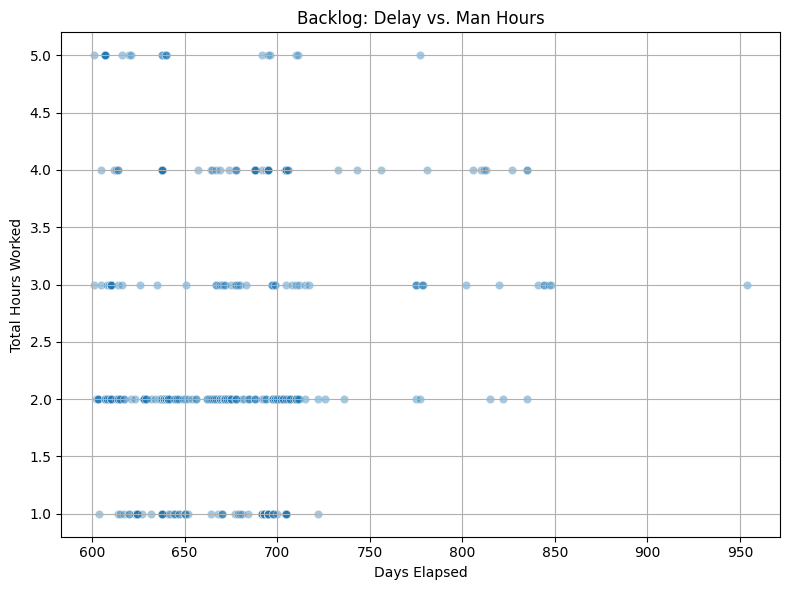

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=backlog_candidates,
    x='days_elapsed',
    y='total_hours_worked',
    alpha=0.4
)
plt.title("Backlog: Delay vs. Man Hours")
plt.xlabel("Days Elapsed")
plt.ylabel("Total Hours Worked")
plt.grid(True)
plt.tight_layout()
plt.show()



In [25]:
summary_table = backlog_candidates.groupby('equipment_nomenclature').agg({
    'days_elapsed': 'mean',
    'total_hours_worked': 'mean',
    'supplies_ordered': 'mean'
}).round(1).sort_values(by='days_elapsed', ascending=False).head(20)

summary_table


,days_elapsed,total_hours_worked,supplies_ordered
equipment_nomenclature,,,
"PLENUM, VENTILAT",835.0,4.0,0.0
TOXIC GAS EXCLUS,835.0,2.0,0.0
800 TON AC NO 1,806.0,4.0,0.0
CR GALY1 VENT HO,781.0,4.0,0.0
XPLENM00000,756.0,4.0,0.0
VLVGATE 1.25IPS,733.0,4.0,0.0
"COIL,MAC-3A COOL",711.0,2.0,0.0
HEATING SYS VENT,706.5,2.0,0.0
VENTILATION ACCE,702.0,2.8,0.0


# Jeffs Code

# Relationship Between Hours Worked and Days Elapsed
<pre>
There is no linear relationship. 

This tells that days_elapsed likely has little to do with the difficulty of the job.
Could focus efforts into delays that cause a job to go unfinished.

Are these jobs being forgotten about, waiting on supplies, simply deemed unimportant? There are many possibities,
but I find this lack of a relationship notable. 
<pre>

In [3]:
filtered_jobs = jobs[
    (jobs['days_elapsed_outlier'] != True) & 
    (jobs['hours_worked_flag'] != True) & 
    (jobs['days_elapsed'].notna())] #23311 records 

filtered_jobs['days_elapsed'].corr(filtered_jobs['total_hours_worked']).round(4) #-0.0565

#Note: Also tried with days_elapsed < 100, got correlation = 0.05

-0.0565

# Hours Worked By Equipment Nomenclature

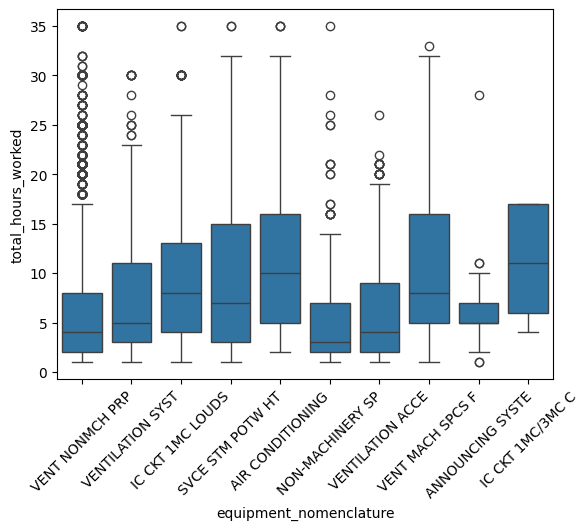

In [20]:
top10 = filtered_jobs['equipment_nomenclature'].value_counts().nlargest(10).index
df_top10 = filtered_jobs[filtered_jobs['equipment_nomenclature'].isin(top10)]

sns.boxplot(x='equipment_nomenclature', y='total_hours_worked', data = df_top10)
plt.xticks(rotation = 45)
plt.show()
#All have at least 188 records
#Shows some sign of relationship between equipment being worked on and # of hours required to complete MA 


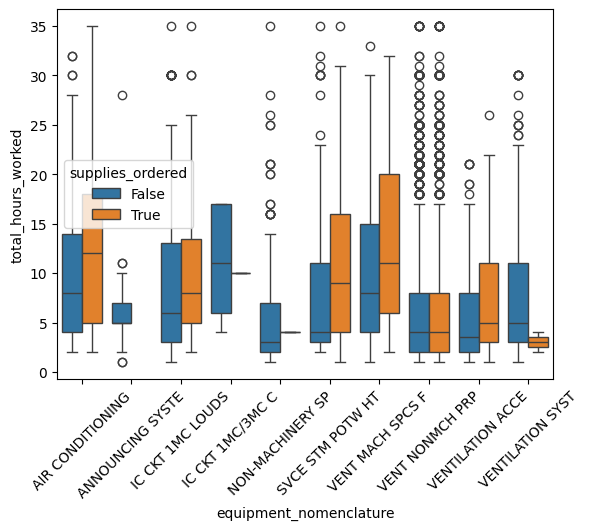

In [31]:
sns.boxplot(x='equipment_nomenclature', y='total_hours_worked', hue='supplies_ordered', data=df_top10)
plt.xticks(rotation=45)
plt.show()


# One way anova 

In [29]:
#Simple Linear Regression Using Equipment Nomenclature to Predict total_hours_worked
df_top10.loc[:,'equipment_nomenclature'] = df_top10['equipment_nomenclature'].astype('category')
model = ols('total_hours_worked ~ C(equipment_nomenclature)', data = df_top10).fit()
#model.rsquared = .045

#ANOVA
#Null: No differences between the means of individuals groups
#H1: Difference between at least 2 groups means
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                  sum_sq       df          F         PR(>F)
C(equipment_nomenclature)   27644.521118      9.0  84.332587  7.283757e-154
Residual                   584328.031302  16043.0        NaN            NaN


In [37]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# If not already cleaned:
df_top10['equipment_nomenclature'] = df_top10['equipment_nomenclature'].astype('category')
df_top10['supplies_ordered'] = df_top10['supplies_ordered'].astype('bool')

# Drop rows with missing values just in case
model_data = df_top10.dropna(subset=['total_hours_worked', 'days_elapsed'])

# Fit model
formula = 'total_hours_worked ~ C(equipment_nomenclature) + supplies_ordered + days_elapsed'
model = ols(formula, data=model_data).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     total_hours_worked   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     70.08
Date:                Tue, 15 Jul 2025   Prob (F-statistic):          2.12e-154
Time:                        16:00:51   Log-Likelihood:                -51624.
No. Observations:               16053   AIC:                         1.033e+05
Df Residuals:                   16041   BIC:                         1.034e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

C:\Users\bengb\AppData\Local\Temp\ipykernel_18756\2741471067.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10['equipment_nomenclature'] = df_top10['equipment_nomenclature'].astype('category')
C:\Users\bengb\AppData\Local\Temp\ipykernel_18756\2741471067.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10['supplies_ordered'] = df_top10['supplies_ordered'].astype('bool')


In [38]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Make sure categorical variables are of type 'category'
categorical_vars = [
    'equipment_nomenclature', 'priority_code', 'action_taken_code',
    'cause_code', 'feasible_with_ship_inventory', 'when_discovered',
    'location_purpose', 'level'
]
for var in categorical_vars:
    df_top10[var] = df_top10[var].astype('category')

df_top10['supplies_ordered'] = df_top10['supplies_ordered'].astype(bool)

# Define formula
formula = """
    total_hours_worked ~
    C(equipment_nomenclature) +
    C(priority_code) +
    C(action_taken_code) +
    C(cause_code) +
    C(feasible_with_ship_inventory) +
    C(when_discovered) +
    C(location_purpose) +
    C(level) +
    supplies_ordered +
    days_elapsed
"""

# Fit model
model = ols(formula, data=df_top10).fit()

# Output summary
print(model.summary())


C:\Users\bengb\AppData\Local\Temp\ipykernel_18756\858027017.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10[var] = df_top10[var].astype('category')
C:\Users\bengb\AppData\Local\Temp\ipykernel_18756\858027017.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10['supplies_ordered'] = df_top10['supplies_ordered'].astype(bool)


                            OLS Regression Results                            
Dep. Variable:     total_hours_worked   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     18.46
Date:                Tue, 15 Jul 2025   Prob (F-statistic):               0.00
Time:                        16:01:00   Log-Likelihood:                -50989.
No. Observations:               16053   AIC:                         1.022e+05
Df Residuals:                   15936   BIC:                         1.031e+05
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

<pre>
Very little predictive power using equipment_nomenclature to predict total_hours_worked
<pre>

# Target Variables

🧭 Step 1: Clarify Your Goal (Target Variable)
Before any modeling or feature selection, nail down what problem you're solving.

Some good candidate targets based on your data:

Target Variable	Description	Good For...
total_hours_worked	How labor-intensive a job is	Predicting workload, staffing needs
days_elapsed	How long a job remains open	Estimating maintenance backlog
supplies_ordered	Whether a job needed supplies (binary)	Predicting logistics support needs
supply_days_waiting	Time spent waiting on parts	Identifying procurement bottlenecks
feasible_with_ship_inventory	Binary outcome, useful for inventory strategy	Supply chain/inventory alignment

Pick one to start — we can always model others next.



# Supplies Ordered

In [39]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import shap

# 1. Prepare data
df = jobs.copy()  # Or df_top10 if you're working with a slice
df = df[df['supplies_ordered'].notna()]

# Drop high-cardinality IDs or clearly non-predictive features
drop_cols = ['uic', 'job_seq', 'csmp_narrative_summary', 'date_closing', 'date_maintenance_action']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

# Target variable
df['supplies_ordered'] = df['supplies_ordered'].astype(int)

# Encode categoricals
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category').cat.codes

# Fill missing
df = df.fillna(-1)

# Features and target
X = df.drop(columns='supplies_ordered')
y = df['supplies_ordered']

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# 3. Train model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# 4. Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# 5. SHAP explainability
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


TypeError: Cannot setitem on a Categorical with a new category (-1), set the categories first

# Relationship between when discovered, cause, deferral reason and days_elapsed

In [35]:
model = ols('days_elapsed ~ C(cause_code) + C(when_discovered_code) + C(deferral_reason_code)', data = jobs).fit()
result = model.summary() #R2 = 0.134
#print(result)
#also considered fitting with filtered_jobs, make a difference of .001 to r2

# Priority 
<pre>
Desirable: 46737
Highly desirable: 503
Essential: 95
Mandatory: 15

Most records in this dataset refer to MAs where it is not urgent to be completed quickly.
<pre>

# Number of Jobs Opened by Month for CVN 74

In [ ]:
cvn74 = jobs[jobs['ship'] == 'CVN74'] 

monthly_counts = cvn74.groupby(cvn74['date_maintenance_action'].dt.to_period('M')).size() #Number of jobs opened each month on CVN74

monthly_counts.index = monthly_counts.index.to_timestamp() #Handles TypeError: float() argument must be a string or a real number, not 'Period'

plt.plot(monthly_counts.index, monthly_counts.values)
plt.xlabel('Month')
plt.xticks(rotation = 45)
plt.ylabel("Number of Jobs Opened")
plt.title("Jobs Opened By Month On CVN 74")

<pre>
There appears to be some meaningful variation from month to month.
Could look into trends/changes during busier or slower times
Specifically, do jobs take longer to complete during busier times?
<pre>

In [ ]:
#Ideas Related to Time and The Number of Jobs Being Worked On Over Time


#Add variable showing # of jobs going on at the beginning of the MA 
#Add variable showing # of jobs that occur with the interval of the MA (date_maintenance_action ---> date_closing)
#For these variables, need to look at the job's ship. Also could look to subset further to work_center

# Next Ideas
<pre>
Predict when_discovered, cause, or deferral_reason
Cases for Each:

deferral_reason: Relatively balanced variable
Knowing why jobs get deferred in advance could help forecast for given types of jobs.
As specific personnel and work centers have specialties, additional information about why a job most often gets pushed back could help personnel plan. 
For example, knowing that a type of job often gets delayed for lack of material could lead to more effort towards montoring supply counts.


cause: Knowing the cause for a type of MA can help us enhance efforts in these areas. 
Cons: 'Normal wear and tear' and 'Other' make up the majority of the records for this variable. 

when_discovered: 
Relatively balanced 
Also, the top 2 most frequent are insightful - Normal operation and during inspection


Predict Engineered Variable: Binary, supplies required (Y/N)

Predict Engineered Variable: Job Took Longer than 8 hours to Complete (Y/N)
<pre>

# Idea: Predict deferral_reason
<pre>
Variables that Could Be Meaningful Predictors:

ship
cause_code
csmp_narrative_summary, equipment_nomenclature
location
priority_code, safety_code, status_code, component_status
when_discovered_code
work_center 
def_narrative, nondef_narrative
type_of_availability_needed


Number of jobs open at that time: One level is Due to ships' force work backlog
<pre>

# Ideas for Enhancing Text Features
<pre>
equipment_nomenclature, csmp_narrative_summary: Vectorization and then grouping most similar entries. Idea: reduce categories from >2100 to ~ 100
def_narrative
<pre>

# Plotting The Distribution for Hours Worked

In [ ]:
traditional_jobs = jobs[(jobs['hours_worked_flag'] != True) & (jobs['job_status'] != 'Open')]  #~ 27k records
#Only consider closed jobs that did not have outlier hours worked
sns.histplot(data=traditional_jobs, x='total_hours_worked', bins=100)
plt.title("Distribution of Total Hours Worked")

#Most jobs only take a few hours

#Considering jobs that did not have outlier hours worked, 31.1% of jobs took more than 8 hours to complete
(traditional_jobs['total_hours_worked'] > 8).mean().round(3)

# Plotting the Distribution of Days Elapsed

In [ ]:
closed_jobs = jobs[(jobs['days_elapsed_outlier'] != True) & (jobs['job_status'] != 'Open')]  #~ 38k records

#Only consider closed jobs that were completed
sns.histplot(data=closed_jobs, x='days_elapsed', bins=100)
plt.title("Distribution of Days Elapsed for Closed Jobs")

(closed_jobs['days_elapsed'] > 30).mean().round(3) #55% of closed jobs took more than 50 days to complete
#76% of closed jobs took more than 10 days to complete

# Takeaway
<pre>
63% of closed jobs take over 30 days to become closed. This is when we remove days_elapsed outliers and only consider Closed jobs.
However, less than a third of the jobs take more than 8 hours (a full work day) to complete.

We could also see from the plots that there is a discrepency between the number of days elapsed and the total number of hours worked.

Also, deferral_reason_code:
35% due to lack of material
24% due to ship's force work backlog/operational priority
14% other/NA
13% lack of facilities/ capabiltiies
10% For ship's force overhaul

It seems that a bulk of the time spent for jobs to be closed is due to supply wait time or operational backlog.

Factors influencing operational backlog: Number of concurrent jobs being worked on
Factors influencing supply wait time: The types of parts being ordered, the quantity of parts, where parts are being ordered from, when the parts are ordered. 

<pre>

# -------------------------------Supply EDA------------------------------------

# Relationship between Supply Days Waiting and Total Days Elapsed

In [ ]:
#There are multiple part orders associated with a job. We should look at the one that takes the longest to complete, making the assumption
#that a job cannot be completed until all parts have been received. 

In [ ]:
supply_sub = supply[(supply['valid_dates'] == True) & (supply['supply_days_waiting_outlier'] == False)]
supply_sub = supply_sub[['job_seq','date_maintenance_action','demand_date','issue_date','date_closing','supply_days_waiting']]

supply_sub['total_days'] = supply_sub['date_closing'] - supply_sub['date_maintenance_action']
supply_sub['total_days'] = supply_sub['total_days'].dt.days

supply_sub['total_days'].corr(supply_sub['supply_days_waiting']).round(3)

# Plotting Supply Wait Time Vs. Total Job Time For Records With Only One Part Order

In [ ]:
# Lets look only at rows where job_seq is present once. 
#see if there is any relationship

#having multiple part orders associated with a job will add noise. Will look at jobs with multiple part orders later

#if any sign of a relationship, could look into group by operations to look at jobs with multiple part orders

unique_jobs = supply_sub['job_seq'].value_counts()
unique_jobs = unique_jobs[unique_jobs == 1].index

supply_unique = supply_sub[supply_sub['job_seq'].isin(unique_jobs)]

sns.scatterplot(x = 'supply_days_waiting', y = 'total_days', data = supply_unique)
plt.title('Supply Wait Vs. Total Wait for Jobs With One Part Order')

supply_unique['supply_days_waiting'].corr(supply_unique['total_days']).round(3) #0.315

# Hypothetical: Assume Total Days > 100 is a Misinput

In [ ]:
unique_jobs = supply_sub['job_seq'].value_counts()
unique_jobs = unique_jobs[unique_jobs == 1].index

supply_unique = supply_sub[(supply_sub['job_seq'].isin(unique_jobs)) & (supply_sub['total_days'] < 100)]

sns.scatterplot(x = 'supply_days_waiting', y = 'total_days', data = supply_unique)
plt.title('Supply Wait Vs. Total Wait for Jobs With One Part Order')

supply_unique['supply_days_waiting'].corr(supply_unique['total_days']).round(3) #0.561 
#dataset is 4998 records 

<pre>
Saw some relationship, so now:
<pre>

# Looking at All Records (More than 1 Part Order)

<pre>
I will assume that a job cannot begin until all parts are received
Look at the earliest demand date and the latest issue date
<pre>

In [ ]:
all_parts = supply_sub.groupby('job_seq').agg({
    'demand_date': 'min',
    'issue_date': 'max'
})
all_parts['all_part_wait'] = (all_parts['issue_date'] - all_parts['demand_date']).dt.days

all_parts.rename(columns = {'demand_date': 'first_demand_date', 'issue_date': 'last_issue_date'}, inplace = True)
#Now, need to join with supply_sub to have total days waiting too


<pre>
Notes: 

supply_sub has all those columns with repeating job_seq
all_parts has unique job_seq

left join
all_parts as left table

since date_maintenance_action and date_closing never differ in supply_sub,
can drop duplicates and keep the time a job_seq occurs
<pre>

In [ ]:
supply_sub_unique = supply_sub.drop_duplicates(subset = 'job_seq', keep = 'first') #11572 rows

supply_sub_unique = supply_sub_unique[['job_seq','total_days','date_maintenance_action','date_closing']]

In [ ]:
dat = pd.merge(supply_sub_unique, all_parts, how = 'left', on = 'job_seq') #Merged data
#Contains job_seq, all_part_wait, total_days

dat = dat[ (dat['total_days'] < 100)] #exclude records with > 100 days open as these feel like outliers (could use or not use this depending on goals)


dat['all_part_wait'].corr(dat['total_days']).round(3) #.603. Increased from when only looking at one part jobs.
#Not too meaningful, makes sense because the time from min date_maintenance_action to max date_closing will naturally capture more 
#variation occuring.
dat #7.7k records

sns.scatterplot(x = 'all_part_wait', y = 'total_days', data = dat)
plt.title('Supply Wait Vs. Total Wait for All Jobs')

# Takeaways:
<pre>
Knowing supply wait time does not provide too much value for knowing total wait time. 
This is also true for hours worked when looking for key contributors to time open. 

I believe there could be some pretty significant flaws in closing out jobs properly in the system. 
If neither hours worked or supply wait time are meaningful signals, something is likely to be off from my perspective. 

If there are no errors and the logging is mostly accurate, it could be that jobs are being forgotten about. 

This could be a key insight. It could be possible that jobs are being completed later than initially intended because they were simply forgotten about/
lost in the worklog. 
<pre>

# Next Ideas
<pre>
Idea 1: Look at lifecycle of job and see which contributes most to days_open

    Could look at # of days between date_maintenance_action and issue_date to see if any unnecessary delays
    Could look at # of days between issue_date and date_closing. 
    See which of these 3 intervals most contributes to full days open
    *Consider including and excluding days_open > 100. Note differences when looking at each.




Idea 2: Look at supply_days_waiting by source_code (feels like this should be meaningful) 
    If noticable differences, could see which factors most influence source_code

            Could investigate other features as well such as niin_nomenclature, ship, issue_apl, issue_eic, unit_of_issue


Idea 3: Compare differences in times waiting between part orders associated with the same job_seq. Inter vs. intra group differences

Idea 4: Pivot away from days open related analysis. Look into comparing jobs that do and do/not require supply orders
    *See if there is a notable difference in the types of jobs that require supply orders and those that do not


Idea 5: Group similar types of jobs and reccomend parts based on past similar jobs. NLP likely needed here to extract info from free form columns
    Notify personnel: Parts likely to be required, parts likely to be ordered before beginning job


Idea 6: Could create a job difficulty metric: # of hours worked, # of parts needed, # of days expected to be open (if others show signal)
<pre>

# ----------------- Idea 1: Lifecylce of Maintenance Actions -----------------

In [ ]:
dat.shape #Reminder for Later: 14330 unique job seq -> 14142 (supply cleaned-remove NA niin) -> 11572 (valid dates and supply days waiting outlier flags)
# -> 7.7k (total days open < 100)
#goes from 11.5k to 7.7k when removing jobs with days open > 100.

In [ ]:
dat['start_to_demand_days'] = (dat['first_demand_date'] - dat['date_maintenance_action']).dt.days
dat = dat.rename(columns = {'all_part_wait': 'demand_to_issue_days'}) #rename all_part_wait for consistent variable name formatting
dat['issue_to_close_days'] = (dat['date_closing'] - dat['last_issue_date']).dt.days

In [ ]:
#reorder columns for logical flow
dat = dat[['job_seq','date_maintenance_action','start_to_demand_days','first_demand_date',
           'demand_to_issue_days','last_issue_date','issue_to_close_days','date_closing','total_days']]

Boxplot for each of the three
Proportion of total time (divide by total days)
correlation between the different durations and total job time

# Adding Feature: Proportions of Total Time Elapsed

In [ ]:
dat['prop_stage1'] = ((dat['start_to_demand_days'] / dat['total_days']) *100).round(1)
dat['prop_stage2'] = ((dat['demand_to_issue_days'] / dat['total_days']) * 100).round(1)
dat['prop_stage3'] = ((dat['issue_to_close_days'] / dat['total_days']) * 100).round(1)

dat[['prop_stage1','prop_stage2','prop_stage3']] = dat[['prop_stage1','prop_stage2','prop_stage3']].fillna(0) #NAs created by div by 0 (total_days = 0)

# Considering Relationships Between Stages

In [ ]:
corr_matrix = dat[['start_to_demand_days','demand_to_issue_days','issue_to_close_days','total_days']].corr().round(2)

corr_pairs = (corr_matrix
              .where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))
              .stack().reset_index()
              )
corr_pairs = corr_pairs.sort_values(by = 0, ascending = False)

corr_pairs.columns = ['Variable 1', 'Variable 2', 'Corr']
print(corr_pairs) #Displays correlation between variables in descending order of correlation

<pre>
Takeaways:
 
- A possible bottleneck exists between the time the parts are received and the time to complete the MA.
    - This could be caused by lack of awareness that parts have arrived, foregetfullness, 
      or simply improper closing of MAs in the system (jobs are not actually taking this long). 
    - One reccomendation could be: Notifications sent to personnel that parts have arrived, so that operations are not delayed longer than necessary. 


- Parts are being ordered in a reasonable amount of time, and not contributing much to overall delays. 

- The amount of time taken for one stage does not have any connection with the amount of time taken for another stage when considering 
subparts of the MA. Stages 1,2,3 of the MA: None of these combinations have any meaningful linear relationship


# Distributions For Each Stage

In [ ]:
cols = ['start_to_demand_days','demand_to_issue_days','issue_to_close_days']

#melt dataframe for seaborn boxplot
dat_melted = dat[cols].melt(var_name = 'Stage',value_name = 'Days')

In [ ]:
sns.boxplot(x = 'Stage', y = 'Days', data = dat_melted)
plt.title("Maintenance Job Time By Stage")

<pre>
Takeaway: 

Most wait time is due to demand_to_issue and issue_to_close stages. 
issue_to_close days has the most variance and contributes slightly more than demand_to_issue to overal days waiting. 

# Saving Job Time Breakdown Breakdown Data For Future Reference

In [ ]:
dat.to_pickle('Notebooks/work_breakdown.pkl') #contains start -> first demand date, first demand date -> last issue date, last issue date -> close date
#7.7k x 12

# My Additional Analysis and Extensions
## Future Work Ideas
- Investigate predictive modeling for maintenance delays
- Develop automated notification system for part arrivals
- Create dashboard for real-time job tracking
- Analyze seasonal patterns in maintenance workload